In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
sns.set(color_codes=True)
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
%matplotlib inline

Using TensorFlow backend.


In [4]:
def parse(x):
  return datetime.strptime(x, '%Y %m %d %H')

df = pd.read_csv('Data/pm25.csv', parse_dates=[['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
df.drop('No', axis=1,inplace=True)

df.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
df.index.name = 'date'
df['pollution'].fillna(0, inplace=True)

#drop the first 24 hours
df = df[24:]
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


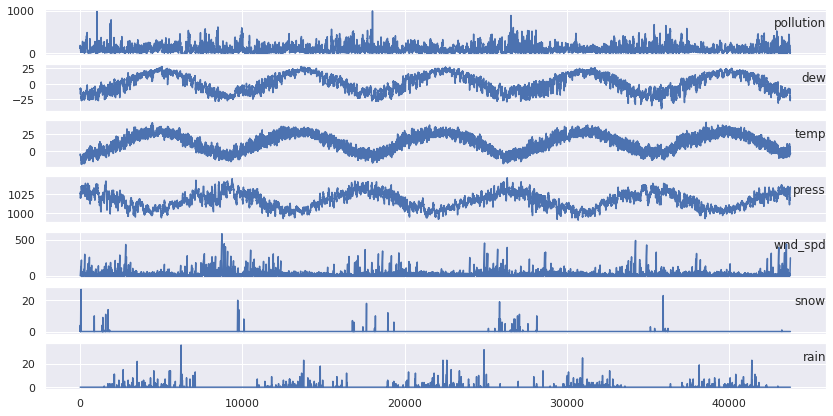

In [0]:
values = df.values
groups = [0,1,2,3,5,6,7]
i = 1
plt.figure(figsize=(14,7))
for group in groups:
  plt.subplot(len(groups),1,i)
  plt.plot(values[:,group])
  plt.title(df.columns[group], y =0.5, loc='right')
  i+=1
plt.show()

In [0]:
df = df.drop_duplicates()

,pollution,dew,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.157603,-0.090818,-0.045519,-0.234414,0.022223,-0.049058
dew,0.157603,1.000000,0.824423,-0.778708,-0.296721,-0.034480,0.125096
temp,-0.090818,0.824423,1.000000,-0.827190,-0.154892,-0.092730,0.049054
press,-0.045519,-0.778708,-0.827190,1.000000,0.185368,0.069033,-0.079863
wnd_spd,-0.234414,-0.296721,-0.154892,0.185368,1.000000,0.021867,-0.010156
snow,0.022223,-0.034480,-0.092730,0.069033,0.021867,1.000000,-0.009556
rain,-0.049058,0.125096,0.049054,-0.079863,-0.010156,-0.009556,1.000000


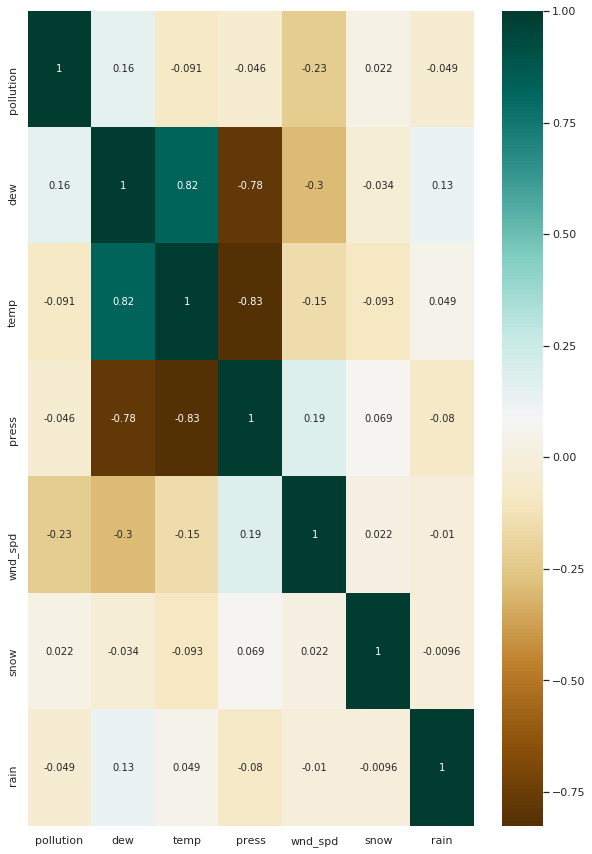

In [7]:
plt.figure(figsize=(10,15))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [12]:
values = df.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


In [13]:
reframed.shape

(43785, 9)

In [20]:
values = reframed.values
#n_train_hours = 365 * 24
n_train_hours = int(0.8*len(reframed))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35028, 1, 8) (35028,) (8757, 1, 8) (8757,)


Train on 35028 samples, validate on 8757 samples
Epoch 1/50
 - 3s - loss: 0.0039 - val_loss: 0.0085
Epoch 2/50
 - 2s - loss: 0.0010 - val_loss: 0.0047
Epoch 3/50
 - 2s - loss: 8.4182e-04 - val_loss: 0.0027
Epoch 4/50
 - 2s - loss: 8.0582e-04 - val_loss: 0.0020
Epoch 5/50
 - 2s - loss: 7.9779e-04 - val_loss: 0.0017
Epoch 6/50
 - 2s - loss: 7.9637e-04 - val_loss: 0.0015
Epoch 7/50
 - 1s - loss: 7.9715e-04 - val_loss: 0.0014
Epoch 8/50
 - 2s - loss: 7.9780e-04 - val_loss: 0.0013
Epoch 9/50
 - 2s - loss: 7.9817e-04 - val_loss: 0.0013
Epoch 10/50
 - 2s - loss: 7.9829e-04 - val_loss: 0.0013
Epoch 11/50
 - 2s - loss: 7.9818e-04 - val_loss: 0.0012
Epoch 12/50
 - 2s - loss: 7.9790e-04 - val_loss: 0.0012
Epoch 13/50
 - 2s - loss: 7.9750e-04 - val_loss: 0.0012
Epoch 14/50
 - 2s - loss: 7.9702e-04 - val_loss: 0.0012
Epoch 15/50
 - 2s - loss: 7.9649e-04 - val_loss: 0.0013
Epoch 16/50
 - 1s - loss: 7.9591e-04 - val_loss: 0.0013
Epoch 17/50
 - 1s - loss: 7.9529e-04 - val_loss: 0.0013
Epoch 18/50
 - 2

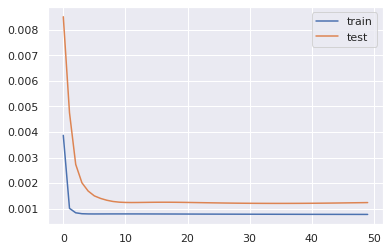

In [21]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [24]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 35.020


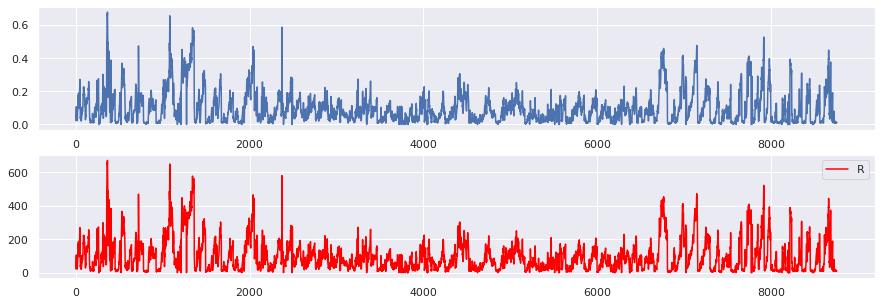

In [50]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(test_y[:,0])
plt.subplot(212)
plt.plot(inv_y, color='red')
